In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

In [2]:
file_path = '/kaggle/input/burgers-solution-1000-v0-01/burger_solution_1000_0.01_upwind_scheme.npy' # change it accordingly

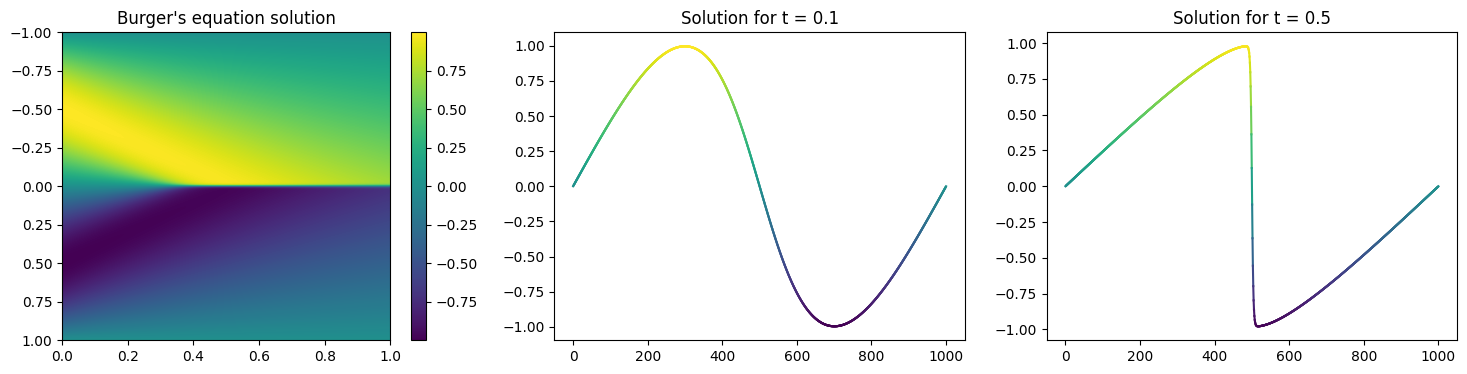

In [4]:
with open(file_path, 'rb') as f:
    # for d in data:
    #     print(d)
    usol =  np.load(f)
    usol = usol.T


    fig, ax = plt.subplots(1,3, figsize=(18,4))
    img = ax[0].imshow(usol, cmap='viridis', aspect='auto', extent=[0, 1, 1, -1])  # 'viridis' is just one of the available color maps
    fig.colorbar(img, ax=ax[0])
    
    x = np.linspace(0, usol.shape[0], usol.shape[0])
    y = usol[:,usol.shape[0]//10]
    y2 = usol[:,usol.shape[0]//2]
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(y.min(), y.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    for i in range(len(x) - 1):
        ax[1].plot(x[i:i+2], y[i:i+2], color=cmap(norm(y[i])))
        
    for i in range(len(x) - 1):
        ax[2].plot(x[i:i+2], y2[i:i+2], color=cmap(norm(y2[i])))
        
    ax[0].set_title("Burger's equation solution")
    ax[1].set_title(f'Solution for t = 0.1')
    ax[2].set_title(f'Solution for t = 0.5')
    
    plt.show()
    fig.savefig('./burgers_equation_v=0.01.pdf')

In [22]:
sampler = qmc.LatinHypercube(d=2)
sample_pos = sampler.random(n=5000)
sample_neg = sampler.random(n=5000)
sample_neg[:,0] = -sample_neg[:,0]

sample = np.vstack([sample_pos, sample_neg])
# print(sample.shape)

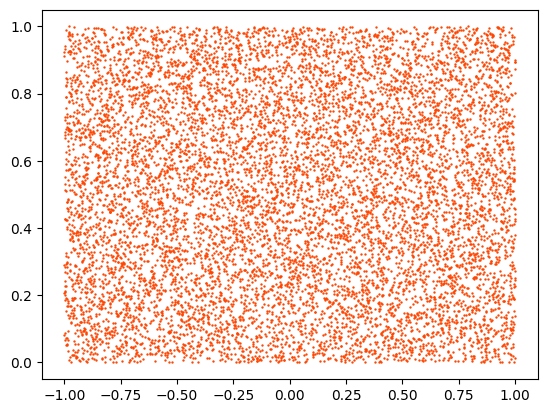

In [51]:
plt.scatter(sample[:,0], sample[:,1], s=0.5, color='orangered')

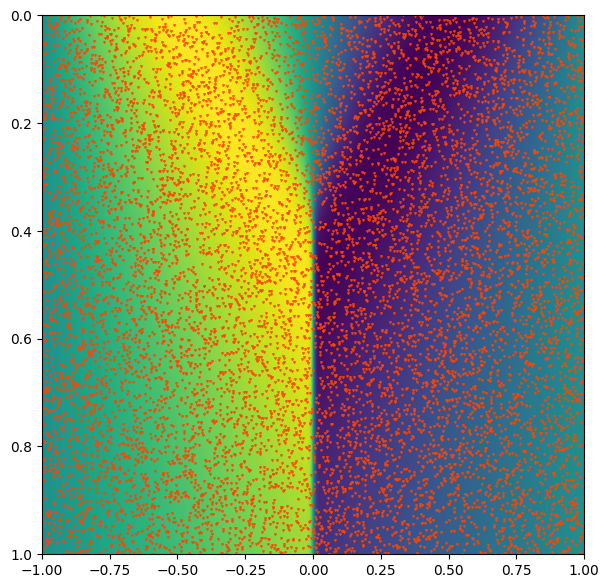

In [52]:
with open(file_path, 'rb') as f:
    usol =  np.load(f)
    fig, ax = plt.subplots(1, figsize=(7,7))
    img = ax.imshow(usol, cmap='viridis', aspect='auto', extent=[-1, 1, 1, 0])
    ax.scatter(sample[:,0], sample[:,1], s=1, color='orangered', marker='v')